In [36]:
# General Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from scipy.stats import norm
from collections import Counter
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.font_manager
%matplotlib inline

In [35]:
# SKlearn Imports
import sklearn
import sklearn.metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, StratifiedShuffleSplit, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import auc, classification_report, recall_score, f1_score, roc_auc_score, confusion_matrix, accuracy_score, precision_score, roc_curve, precision_recall_curve, average_precision_score
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

In [4]:
df = pd.read_csv('comp_bank_clean.csv')

In [5]:
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,0.035490


## No null-values

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 95 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [7]:
X = df.drop('Bankrupt?', axis=1)
y = df['Bankrupt?']

## Filtering Columns based on Variance

In [8]:
data_mean = np.mean(X, axis=0)

variance = np.var(X/data_mean, axis=0)
var_df = pd.DataFrame(variance,columns=['variance'])
var_df.sort_values(by='variance').style.background_gradient(sns.light_palette('blue', as_cmap=True))

,variance
Operating Profit Growth Rate,0.000161
Operating Profit Rate,0.000170
Cash Flow to Sales,0.000193
Working capitcal Turnover Rate,0.000227
Working Capital/Equity,0.000252
Pre-tax net Interest Rate,0.000261
Continuous interest rate (after tax),0.000263
After-tax net Interest Rate,0.000283
Net Income to Stockholder's Equity,0.000299
Interest Expense Ratio,0.000317


In [11]:
vt = VarianceThreshold(0.01).fit(X/data_mean)

vt_transform = vt.transform(X/data_mean)

In [18]:
high_var_cols = X.columns[vt.get_support()]
low_var_cols = X.columns[~vt.get_support()]

print("Removed cols :",len(low_var_cols))
print("Remaining cols :",len(high_var_cols))

Removed cols : 39
Remaining cols : 55


In [21]:
low_var = low_var_cols.unique()

for c in low_var:
    del df[c]

KeyError: ' Operating Gross Margin'

In [22]:
df.shape

(6819, 56)

In [23]:
X = df.drop('Bankrupt?', axis=1)
y = df['Bankrupt?']

In [25]:
# Correlation
corr_mat = np.corrcoef(vt_transform, rowvar=False)
corr_mat = pd.DataFrame(corr_mat)

corr_mat.style.background_gradient(sns.light_palette('blue', as_cmap=True))

In [62]:
# SCALE DATA

scaler = StandardScaler()

scaler.fit(X)

X = scaler.transform(X)

In [26]:
X.shape

(6819, 55)

In [27]:
X_train_n, X_test, y_train_n, y_test = train_test_split(X, y, test_size=0.15, random_state=42) 

In [29]:
# Balancing the Training Data
oversample = SMOTE()
X_train,y_train =oversample.fit_resample(X_train_n, y_train_n)

In [30]:
X_train.shape

(11238, 55)

In [31]:
# 4 Folds
kf = KFold(shuffle=True, random_state=42, n_splits=4)

## Basic Modeling Analysis

In [69]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, min_samples_leaf= 1,random_state=42, max_features = 'log2', min_samples_split = 2)



gdbr = GradientBoostingClassifier(learning_rate=0.1,
                                 n_estimators=100, random_state=42)

dtr = DecisionTreeClassifier(random_state=42)

In [70]:
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

gdbr.fit(X_train, y_train)
y_pred_gdbr = gdbr.predict(X_test)

dtr.fit(X_train, y_train)
y_pred_dtr = dtr.predict(X_test)

In [71]:
def cr_func(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    return classification_report(y_test, model.predict(X_test))

In [72]:
print(cr_func(rf, X_train, X_test, y_train, y_test))
print(cr_func(gdbr, X_train, X_test, y_train, y_test))
print(cr_func(dtr, X_train, X_test, y_train, y_test))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       652
           1       0.41      0.53      0.46        30

    accuracy                           0.95       682
   macro avg       0.69      0.75      0.72       682
weighted avg       0.95      0.95      0.95       682

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       652
           1       0.31      0.73      0.44        30

    accuracy                           0.92       682
   macro avg       0.65      0.83      0.70       682
weighted avg       0.96      0.92      0.93       682

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       652
           1       0.28      0.50      0.36        30

    accuracy                           0.92       682
   macro avg       0.63      0.72      0.66       682
weighted avg       0.95      0.92      0.93       682



# Gradient Boosting Classifier with GridSearchCV

### Test 1

In [79]:
grad_boost_grid_2 = {'learning_rate': [.19],
                          'max_depth': [16],
                          'min_samples_leaf': [14],
                          'max_features': [19],
                          'n_estimators': [140]}

gb_gridsearch_2 = GridSearchCV(GradientBoostingClassifier(),
                             grad_boost_grid_2,
                             cv=kf,
                             n_jobs=-1,
                             verbose=2,
                             scoring='f1')
gb_gridsearch_2.fit(X_train, y_train)

print("best parameters:", gb_gridsearch_2.best_params_)

best_gb_model_2 = gb_gridsearch_2.best_estimator_

# Predict test set labels
y_pred_2 = best_gb_model_2.predict(X_test)

# Classification Rreport and Accuracy Score
print(classification_report(y_test, y_pred_2))
print(accuracy_score(y_test, y_pred_2).round(5)*100)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
best parameters: {'learning_rate': 0.19, 'max_depth': 16, 'max_features': 19, 'min_samples_leaf': 14, 'n_estimators': 140}
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.70      0.60      0.65        43

    accuracy                           0.97      1023
   macro avg       0.84      0.80      0.82      1023
weighted avg       0.97      0.97      0.97      1023

97.263


### Test 2

In [80]:
grad_boost_grid_2 = {'learning_rate': [.19],
                          'max_depth': [16],
                          'min_samples_leaf': [14],
                          'max_features': [19],
                          'n_estimators': [140]}

gb_gridsearch_2 = GridSearchCV(GradientBoostingClassifier(),
                             grad_boost_grid_2,
                             cv=kf,
                             n_jobs=-1,
                             verbose=2,
                             scoring='f1')
gb_gridsearch_2.fit(X_train, y_train)

print("best parameters:", gb_gridsearch_2.best_params_)

best_gb_model_2 = gb_gridsearch_2.best_estimator_

# Predict test set labels
y_pred_2 = best_gb_model_2.predict(X_test)

# Classification Rreport and Accuracy Score
print(classification_report(y_test, y_pred_2))
print(accuracy_score(y_test, y_pred_2).round(5)*100)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
best parameters: {'learning_rate': 0.19, 'max_depth': 16, 'max_features': 19, 'min_samples_leaf': 14, 'n_estimators': 140}
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.67      0.60      0.63        43

    accuracy                           0.97      1023
   macro avg       0.82      0.80      0.81      1023
weighted avg       0.97      0.97      0.97      1023

97.06700000000001


### Test 3 (Best Model)

In [77]:
grad_boost_grid = {'learning_rate': [.19],
                          'max_depth': range(15,19),
                          'min_samples_leaf': range(12,16),
                          'max_features': range(15,21),
                          'n_estimators': [140]}

gb_gridsearch = GridSearchCV(GradientBoostingClassifier(),
                             grad_boost_grid,
                             cv=kf,
                             n_jobs=-1,
                             verbose=2,
                             scoring='f1')
gb_gridsearch.fit(X_train, y_train)

print("best parameters:", gb_gridsearch.best_params_)

best_gb_model = gb_gridsearch.best_estimator_

# Predict test set labels
y_pred = best_gb_model.predict(X_test)

# Classification Rreport and Accuracy Score
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred).round(5)*100)

Fitting 4 folds for each of 96 candidates, totalling 384 fits
best parameters: {'learning_rate': 0.19, 'max_depth': 16, 'max_features': 19, 'min_samples_leaf': 14, 'n_estimators': 140}
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.72      0.60      0.66        43

    accuracy                           0.97      1023
   macro avg       0.85      0.80      0.82      1023
weighted avg       0.97      0.97      0.97      1023

97.361


# Best Gradient Boost Model

In [167]:
print(best_gb_model)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred).round(5)*100)

GradientBoostingClassifier(learning_rate=0.19, max_depth=18, max_features=16,
                           min_samples_leaf=16, n_estimators=120)
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.73      0.63      0.68        43

    accuracy                           0.97      1023
   macro avg       0.86      0.81      0.83      1023
weighted avg       0.97      0.97      0.97      1023

97.458


In [168]:
roc_auc_score(y_test,y_pred).round(4)

0.8089

# KNN

In [113]:
knn = KNeighborsClassifier(n_neighbors=2)


# Fit the classifier to the training data
knn.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred_knn = knn.predict(X_test)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))
print(accuracy_score(y_test, y_pred_knn).round(5)*100)

[[947  33]
 [ 12  31]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       980
           1       0.48      0.72      0.58        43

    accuracy                           0.96      1023
   macro avg       0.74      0.84      0.78      1023
weighted avg       0.97      0.96      0.96      1023

95.601


In [166]:
roc_auc_score(y_test,y_pred_knn).round(4)

0.8436

In [102]:
neighbors = list(range(1,20))

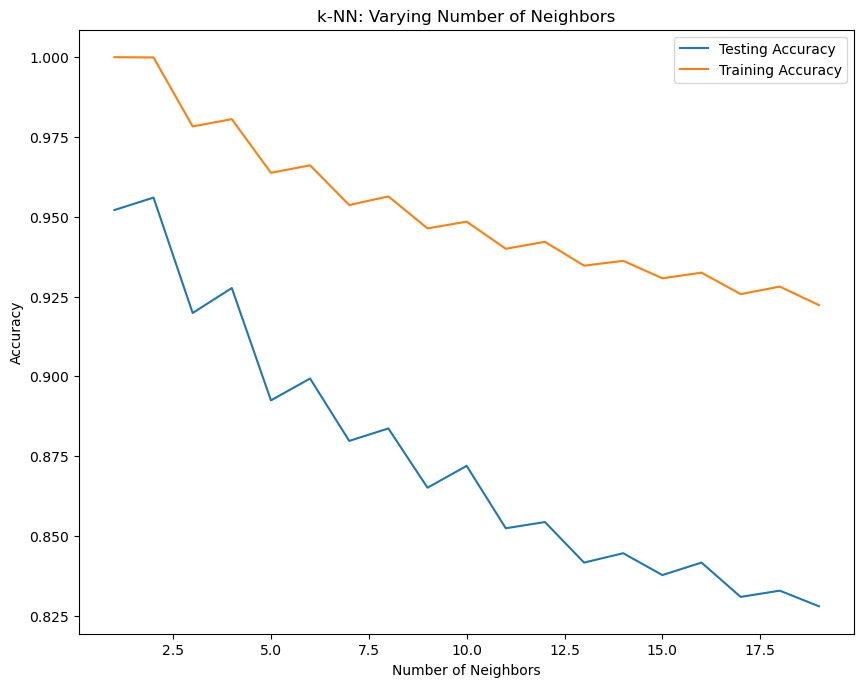

In [105]:
# Setup arrays to store train and test accuracies
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)

    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
figure(figsize=(10, 8), dpi=100)
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

# Random Forest

In [115]:
random_forest_grid = {'max_depth': [23],
                      'max_features': [10],
                      'min_samples_split': [7],
                      'min_samples_leaf': [2],
                      'bootstrap': [False],
                      'n_estimators': [160,165,170,175],
                      'random_state': [42]}

rf_gridsearch = GridSearchCV(RandomForestClassifier(),
                             random_forest_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='f1')
rf_gridsearch.fit(X_train, y_train)

print("best parameters:", rf_gridsearch.best_params_)

best_rf_model = rf_gridsearch.best_estimator_

# Predict test set labels
y_pred_rf = best_rf_model.predict(X_test)

# Classification Rreport and Accuracy Score
print(classification_report(y_test, y_pred_rf))
print(accuracy_score(y_test, y_pred_rf).round(5)*100)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
best parameters: {'bootstrap': False, 'max_depth': 23, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 160, 'random_state': 42}
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       980
           1       0.62      0.70      0.66        43

    accuracy                           0.97      1023
   macro avg       0.81      0.84      0.82      1023
weighted avg       0.97      0.97      0.97      1023

96.97


In [161]:
 metrics.roc_auc_score(y_test,y_pred_rf).round(4)

0.8397

# Deep Learning

In [122]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

In [125]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
dl = Sequential()
dl.add(Dense(units=30,activation='relu'))

dl.add(Dense(units=15,activation='relu'))


dl.add(Dense(units=1,activation='sigmoid'))

# For a binary classification problem
dl.compile(loss='binary_crossentropy', optimizer='adam')

In [126]:
dl.fit(x=X_train, 
          y=y_train, 
          epochs=200,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/200
372/372 [==============================] - 1s 934us/step - loss: 0.3489 - val_loss: 0.3157
Epoch 2/200
372/372 [==============================] - 0s 730us/step - loss: 0.2203 - val_loss: 0.2973
Epoch 3/200
372/372 [==============================] - 0s 650us/step - loss: 0.1821 - val_loss: 0.2981
Epoch 4/200
372/372 [==============================] - 0s 717us/step - loss: 0.1561 - val_loss: 0.3049
Epoch 5/200
372/372 [==============================] - 0s 714us/step - loss: 0.1372 - val_loss: 0.3089
Epoch 6/200
372/372 [==============================] - 0s 701us/step - loss: 0.1219 - val_loss: 0.3456
Epoch 7/200
372/372 [==============================] - 0s 672us/step - loss: 0.1093 - val_loss: 0.3735
Epoch 8/200
372/372 [==============================] - 0s 685us/step - loss: 0.0985 - val_loss: 0.4072
Epoch 9/200
372/372 [==============================] - 0s 781us/step - loss: 0.0878 - val_loss: 0.4228
Epoch 10/200
372/372 [==============================] - 0s 750us/step - l

<AxesSubplot:>

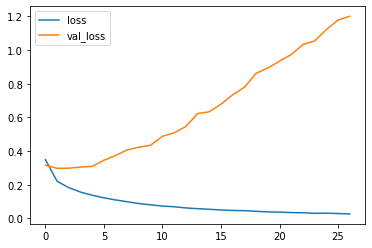

In [127]:
model_loss = pd.DataFrame(dl.history.history)
model_loss.plot()

In [128]:
dl = Sequential()

# 1st layer
dl.add(Dense(units=30,activation='relu'))
dl.add(Dropout(0.5))

# 2nd layer
dl.add(Dense(units=20,activation='relu'))
dl.add(Dropout(0.5))

# 3rd layer
dl.add(Dense(units=10,activation='relu'))
dl.add(Dropout(0.5))


# Final Layer
dl.add(Dense(units=1,activation='sigmoid'))
dl.compile(loss='binary_crossentropy', optimizer='adam')

In [129]:
dl.fit(x=X_train, 
          y=y_train, 
          epochs=600,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/600
372/372 [==============================] - 1s 1ms/step - loss: 0.6508 - val_loss: 0.4977
Epoch 2/600
372/372 [==============================] - 0s 807us/step - loss: 0.4945 - val_loss: 0.3430
Epoch 3/600
372/372 [==============================] - 0s 748us/step - loss: 0.4090 - val_loss: 0.2924
Epoch 4/600
372/372 [==============================] - 0s 820us/step - loss: 0.3656 - val_loss: 0.2947
Epoch 5/600
372/372 [==============================] - 0s 781us/step - loss: 0.3347 - val_loss: 0.2477
Epoch 6/600
372/372 [==============================] - 0s 734us/step - loss: 0.3118 - val_loss: 0.2522
Epoch 7/600
372/372 [==============================] - 0s 714us/step - loss: 0.2730 - val_loss: 0.2534
Epoch 8/600
372/372 [==============================] - 0s 733us/step - loss: 0.2649 - val_loss: 0.2686
Epoch 9/600
372/372 [==============================] - 0s 804us/step - loss: 0.2550 - val_loss: 0.2758
Epoch 10/600
372/372 [==============================] - 0s 849us/step - los

<AxesSubplot:>

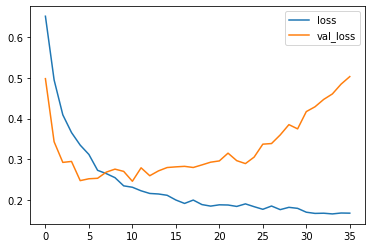

In [130]:
model_loss = pd.DataFrame(dl.history.history)
model_loss.plot()

In [180]:
dl_pred = dl.predict_classes(X_test)

In [181]:
print(classification_report(y_test,dl_pred))

print(f'Accuracy Score: {accuracy_score(y_test, dl_pred).round(5)*100}')

              precision    recall  f1-score   support

           0       0.99      0.93      0.95       980
           1       0.29      0.70      0.41        43

    accuracy                           0.92      1023
   macro avg       0.64      0.81      0.68      1023
weighted avg       0.96      0.92      0.93      1023

Accuracy Score: 91.593


In [158]:
print(confusion_matrix(y_test,dl_pred))

[[907  73]
 [ 13  30]]


In [182]:
 metrics.roc_auc_score(y_test,dl_pred).round(4)

0.8116

# Logisitic Regression

In [136]:
lr = LogisticRegression(max_iter=10000000, n_jobs = -1)

In [137]:
# Fit the classifier to the training data
lr.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred_lr = lr.predict(X_test)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
print(f'Accuracy Score: {accuracy_score(y_test, y_pred_lr).round(5)*100}')

[[856 124]
 [  6  37]]
              precision    recall  f1-score   support

           0       0.99      0.87      0.93       980
           1       0.23      0.86      0.36        43

    accuracy                           0.87      1023
   macro avg       0.61      0.87      0.65      1023
weighted avg       0.96      0.87      0.91      1023

Accuracy Score: 87.292


# Decision Tree

In [143]:
# Import DecisionTreeRegressor from sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# Instantiate dt
dt = DecisionTreeClassifier(random_state=42)

# Fit dt to the training set
dt.fit(X_train, y_train)

# Compute y_pred
y_pred_dt= dt.predict(X_test)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))
print(f'Accuracy Score: {accuracy_score(y_test, y_pred_dt).round(5)*100}')

[[941  39]
 [ 15  28]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       980
           1       0.42      0.65      0.51        43

    accuracy                           0.95      1023
   macro avg       0.70      0.81      0.74      1023
weighted avg       0.96      0.95      0.95      1023

Accuracy Score: 94.721


In [149]:
dt.predict_proba(X_test)[:,1]

array([0., 0., 0., ..., 0., 0., 0.])

# Graphs and Charts

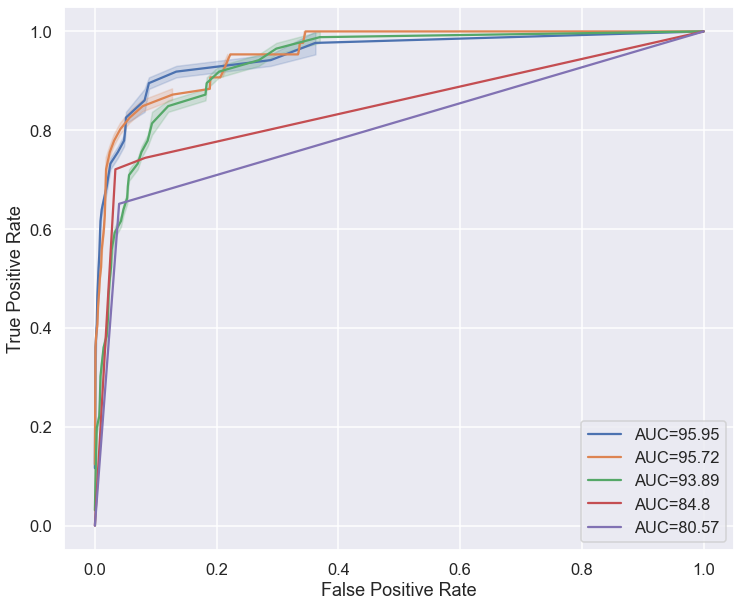

<Figure size 432x288 with 0 Axes>

In [308]:
model_lst = [best_gb_model,best_rf_model, lr, knn, dt]
plt.figure(figsize=(12,10))
def curve(lst,X_test=X_test,y_test=y_test):
    for model in lst:
        

        #define metrics
        y_pp_dt = model.predict_proba(X_test)[::,1]
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pp_dt)
        auc = metrics.roc_auc_score(y_test, y_pp_dt).round(4)*100

        #create ROC curve
        sns.set_theme(context = 'paper')
        sns.set_context("talk")
        sns.lineplot(fpr,tpr,label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()
    
curve(model_lst)

plt.tight_layout()


In [228]:
sns.set_theme(style="whitegrid")

auc_lst = []


    
for model in model_lst:
        #define metrics
    y_pp_dt = model.predict_proba(X_test)[::,1]

    auc = metrics.roc_auc_score(y_test, y_pp_dt).round(4)
        
    auc_lst.append(auc)
        

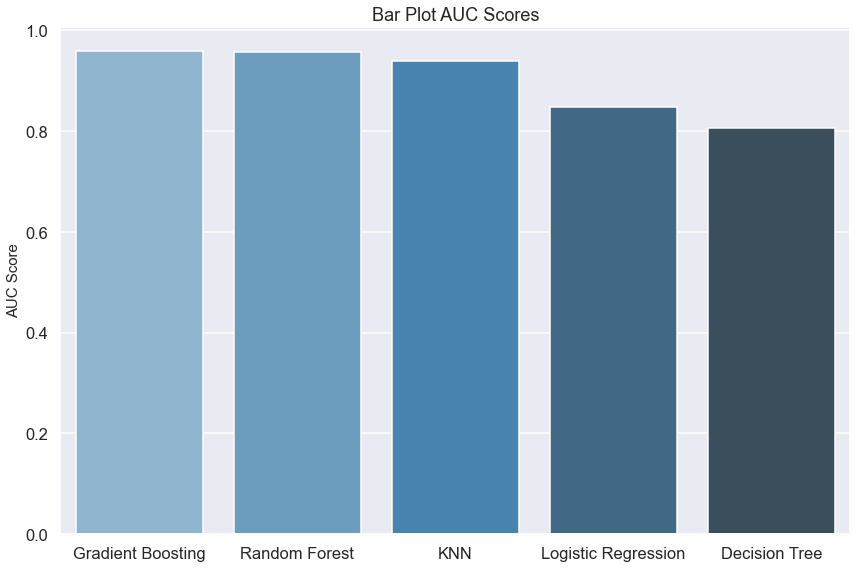

In [305]:
auc_lst
model_lst_names = ['Gradient Boosting', 'Random Forest', 'KNN', 'Logistic Regression','Decision Tree']
plt.figure(figsize=(12,8))
sns.barplot(x=model_lst_names, y=auc_lst, palette="Blues_d")

sns.set_theme(context = 'paper')
sns.set_context("paper")

plt.ylabel("AUC Score", size=15)
plt.title("Bar Plot AUC Scores", size=18)
plt.tight_layout()

# ROC Graph

In [ ]:
plt.figure()



for m in models:
    model = m['model'] # select the model
    model.fit(x_train, y_train) # train the model
    y_pred=model.predict(x_test) # predict the test data
    
    
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(x_test)[:,1])
    
    
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(x_test))
    
    
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
    
    
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

## Pie Charts

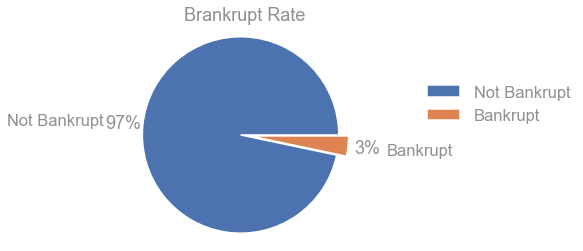

In [310]:
fig, ax = plt.subplots()
sns.set_theme(context = 'paper')
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#909090'
plt.rcParams['axes.labelcolor']= '#909090'
plt.rcParams['xtick.color'] = '#909090'
plt.rcParams['ytick.color'] = '#909090'
plt.rcParams['font.size']=12
labels = ['Not Bankrupt', 
         'Bankrupt']
percentages = [967, 33]
explode=(.1,0)

sns.set_context("talk")
ax.pie(percentages, explode=explode, labels=labels,  
       autopct='%1.0f%%', 
       shadow=False, startangle=0,   
       pctdistance=1.2,labeldistance=1.4)
ax.axis('equal')
ax.set_title("Brankrupt Rate")
ax.legend(frameon=False, bbox_to_anchor=(1,0.8))

## Bar Chart

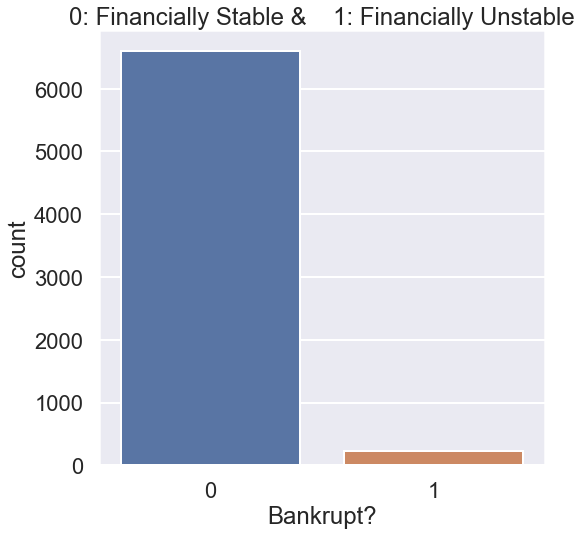

In [388]:
sns.set_theme(context = 'paper')

sns.set_context("poster")
plt.figure(figsize = (8,8))
sns.countplot(x = 'Bankrupt?', data = df);
plt.title('0: Financially Stable &    1: Financially Unstable');

## Histograms

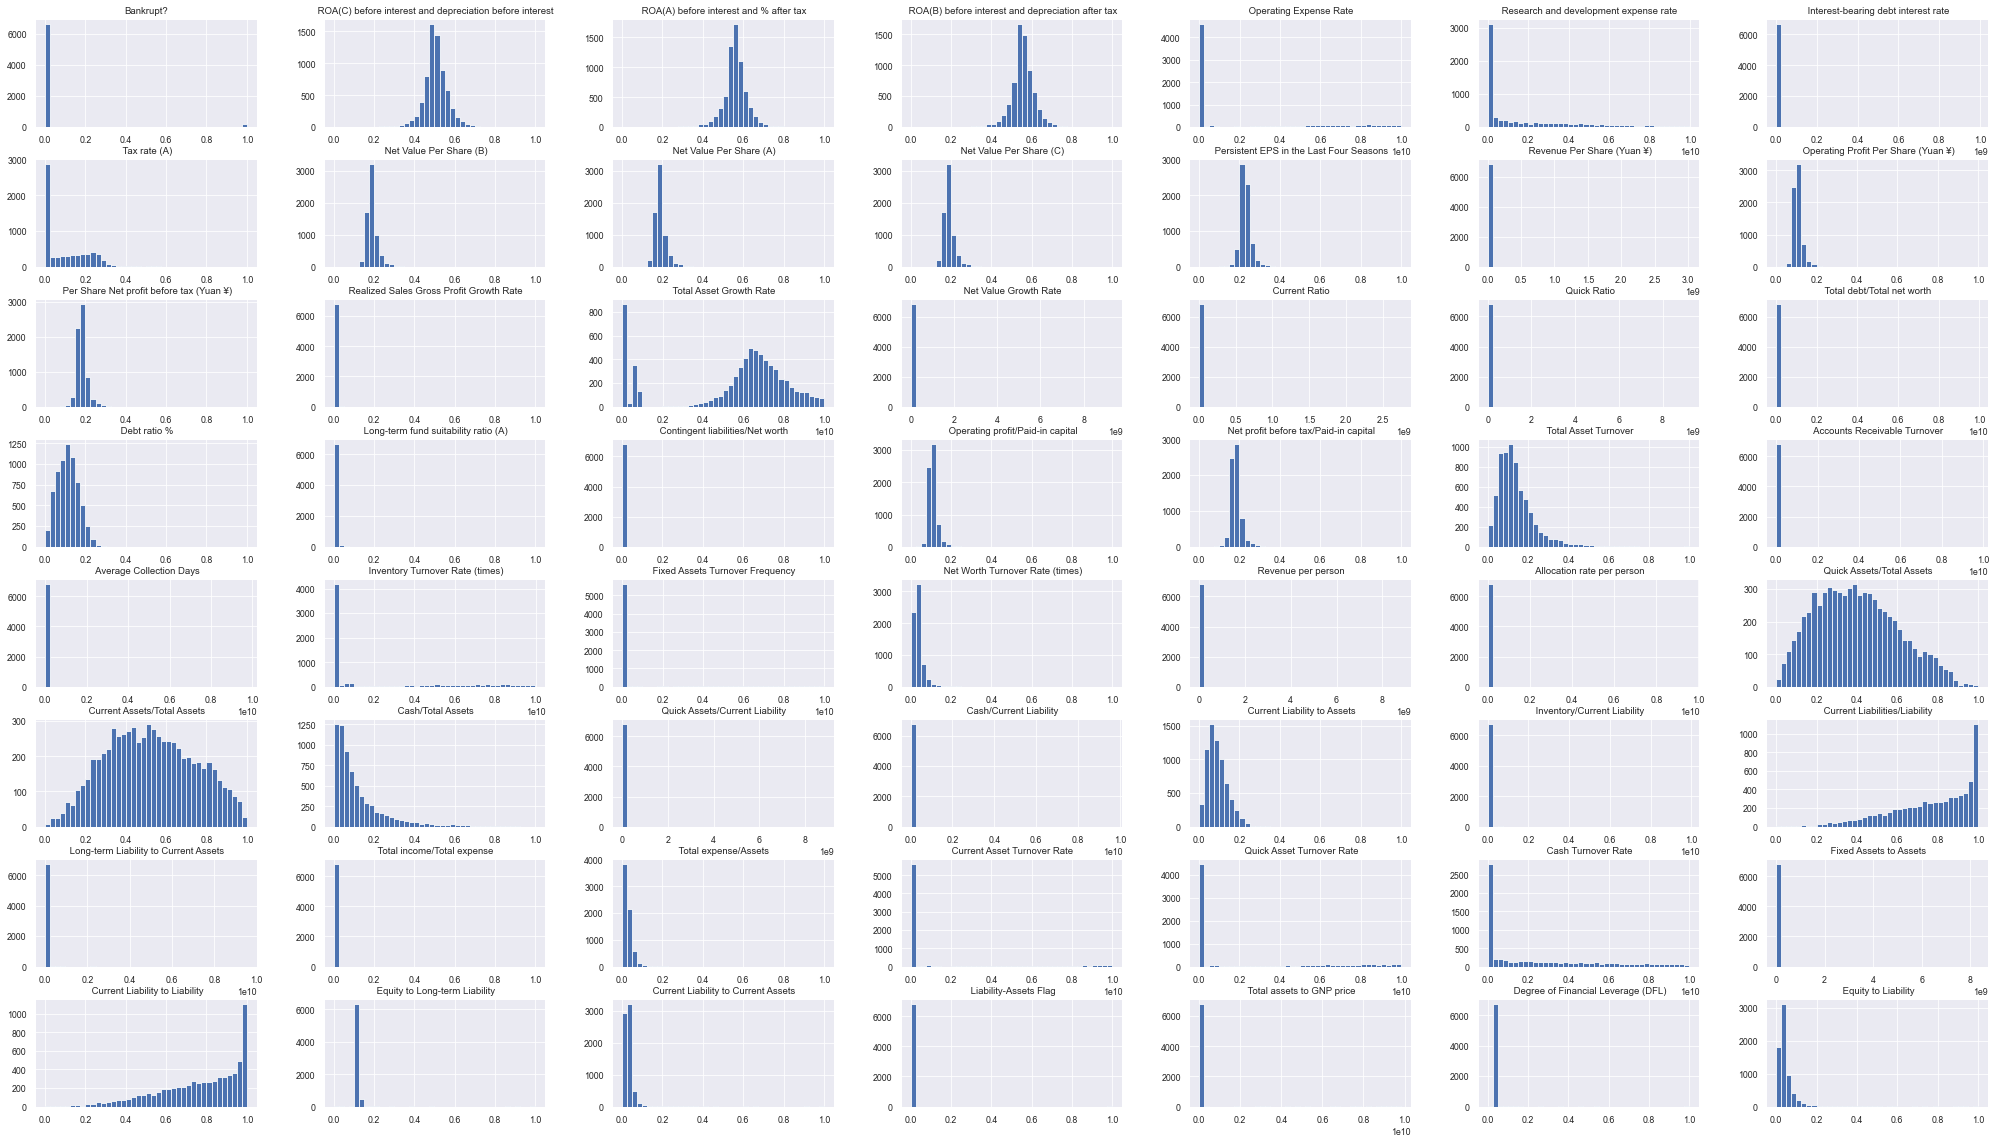

In [287]:
df.hist(bins = 40, figsize = (35,20))
plt.show()

## Feature Importance

Feature: 0, Score: 0.01148
Feature: 1, Score: 0.00424
Feature: 2, Score: 0.09211
Feature: 3, Score: 0.00416
Feature: 4, Score: 0.01504
Feature: 5, Score: 0.00010
Feature: 6, Score: 0.00572
Feature: 7, Score: 0.00569
Feature: 8, Score: 0.00489
Feature: 9, Score: 0.00341
Feature: 10, Score: 0.24422
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00534
Feature: 13, Score: 0.02205
Feature: 14, Score: 0.00501
Feature: 15, Score: 0.02873
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00370
Feature: 20, Score: 0.07636
Feature: 21, Score: 0.00798
Feature: 22, Score: 0.01881
Feature: 23, Score: 0.01328
Feature: 24, Score: 0.03389
Feature: 25, Score: 0.01184
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00563
Feature: 29, Score: 0.01754
Feature: 30, Score: 0.00555
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.01240
Feature: 34, Score: 0.00894
Feature: 35, Score: 0.01201
Fe

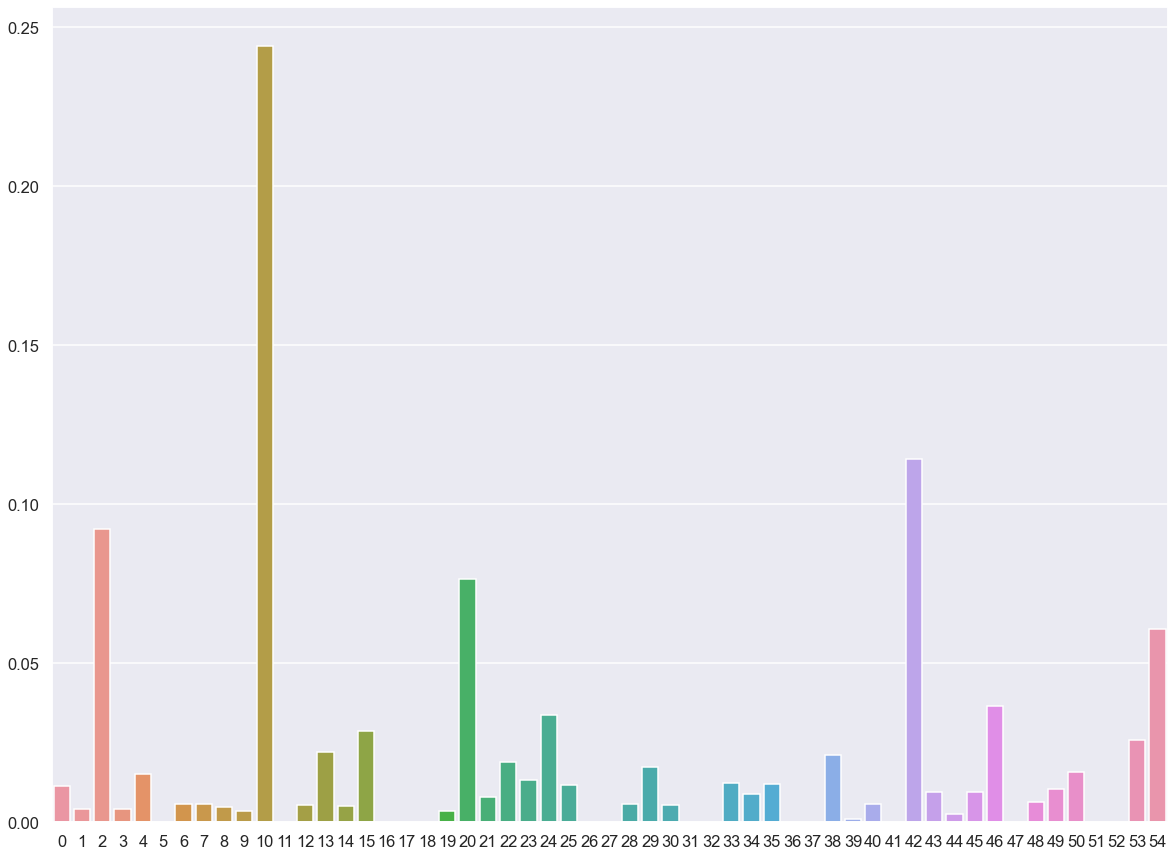

In [328]:
importance = best_gb_model.feature_importances_
# summarize feature importance
plt.figure(figsize=(20,15))
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
sns.set_context("talk")
sns.barplot([x for x in range(len(importance))], importance,)
plt.show()

In [324]:
df.columns[[2,10,13,15,20,24,38,42,46,53,54]]

Index([' ROA(A) before interest and % after tax', ' Net Value Per Share (C)',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Realized Sales Gross Profit Growth Rate',
       ' Total debt/Total net worth', ' Operating profit/Paid-in capital',
       ' Cash/Current Liability', ' Long-term Liability to Current Assets',
       ' Quick Asset Turnover Rate', ' Total assets to GNP price',
       ' Degree of Financial Leverage (DFL)'],
      dtype='object')

In [385]:
two_percent = [' Cash/Current Liability',
       ' Operating Profit Per Share (Yuan ¥)',' Total assets to GNP price',
       ' Realized Sales Gross Profit Growth Rate',
        ' Operating profit/Paid-in capital',
       ' Quick Asset Turnover Rate', 
       ' Degree of Financial Leverage (DFL)',' Total debt/Total net worth',' ROA(A) before interest and % after tax',' Long-term Liability to Current Assets',' Net Value Per Share (C)']
len(two_percent)

11

In [386]:
feat_perc = [2.131, 2.205,2.595, 2.873,  3.389,   3.649,  6.079, 07.636,9.211,11.416,24.422]
np.sum(feat_perc)

75.606

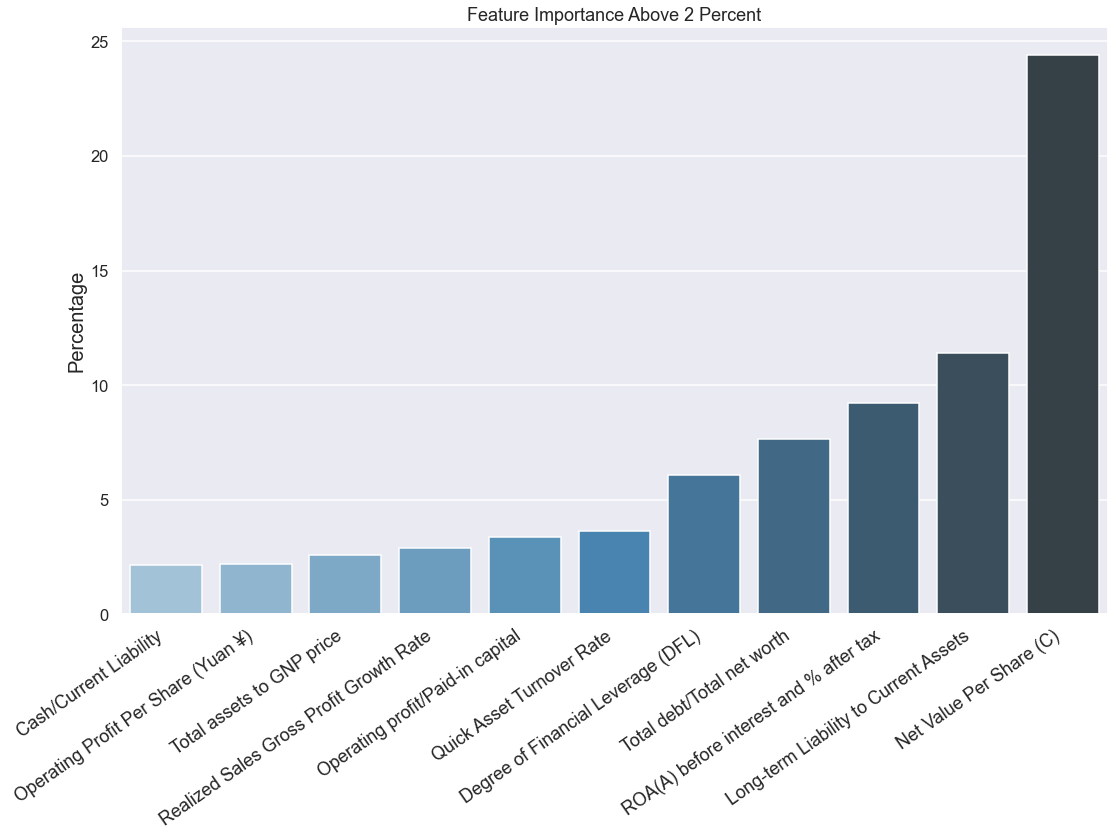

In [387]:
plt.figure(figsize=(16, 12))
sns.set_context("talk")
chart = sns.barplot(x=two_percent, y=feat_perc, palette=sns.color_palette("Blues_d", n_colors=len(two_percent)))
chart.set_xticklabels(chart.get_xticklabels(), rotation=35, horizontalalignment='right', size =18)

plt.ylabel("Percentage", size=20)
plt.title("Feature Importance Above 2 Percent", size=18)
plt.tight_layout()
plt.show()

## Confusion Matrix

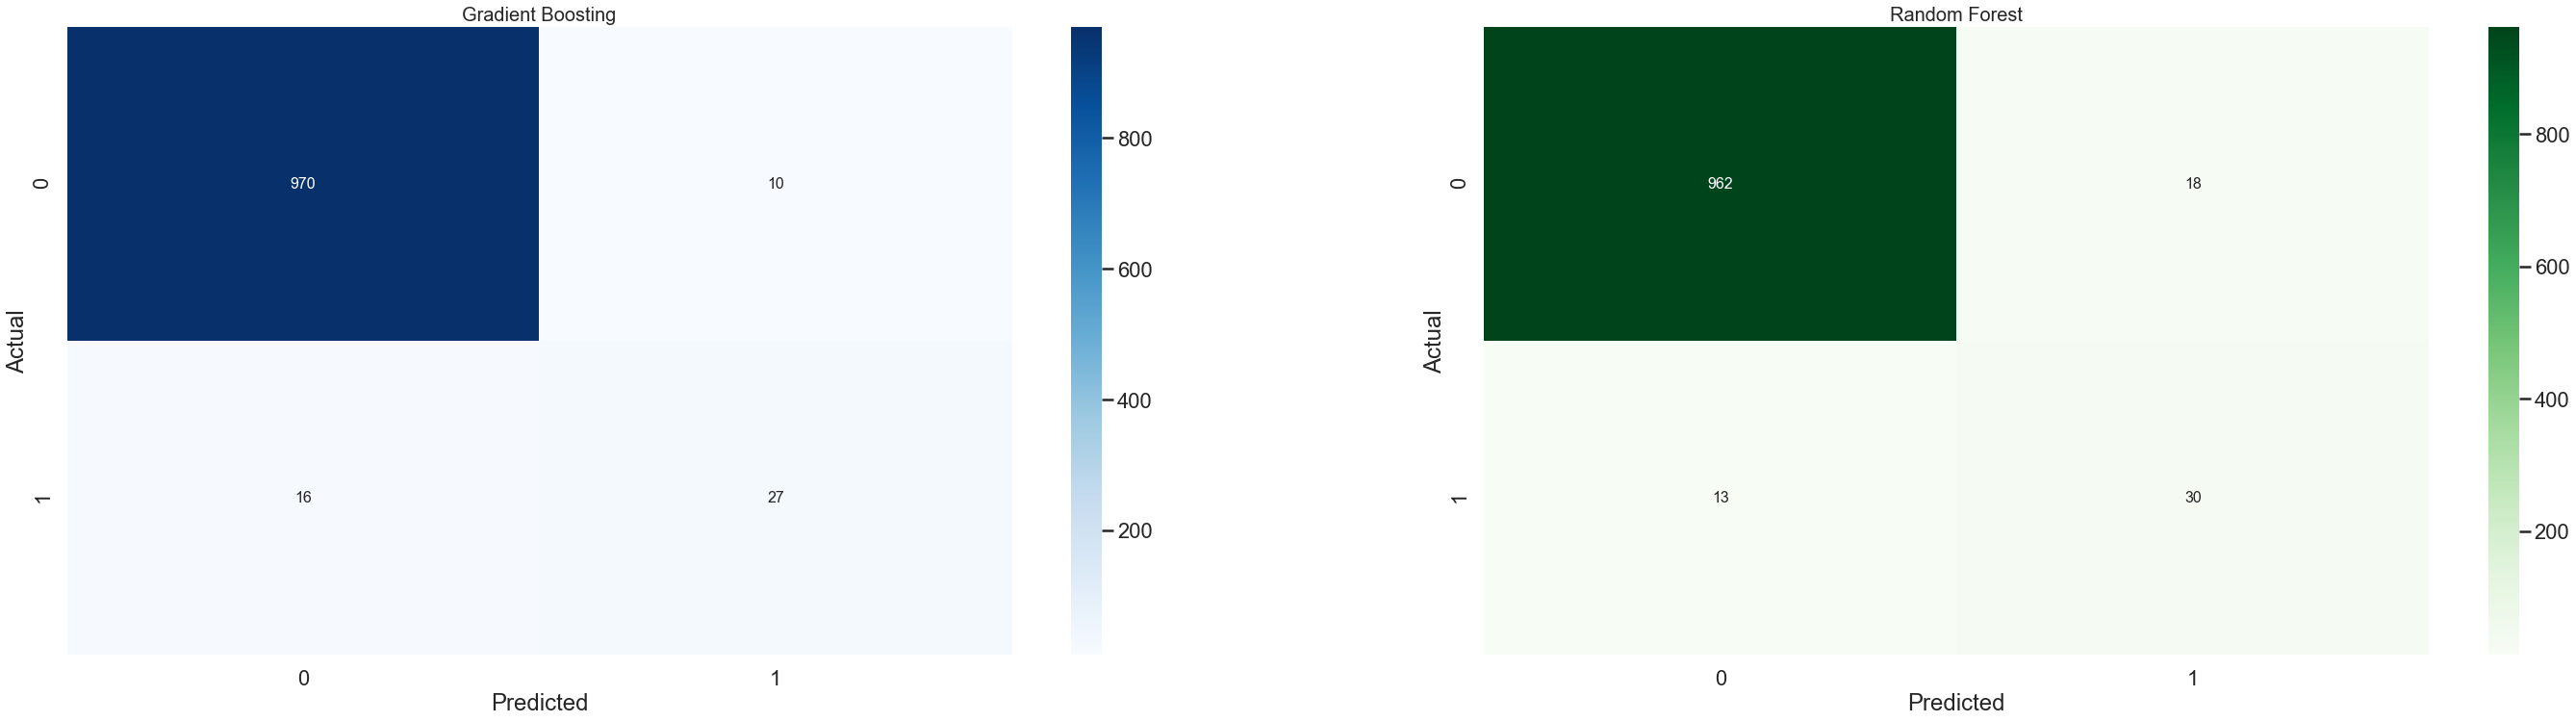

In [400]:
# Plotting confusion matrix for each classifier

conf_mx0 = confusion_matrix(y_test,y_pred)
conf_mx1 = confusion_matrix(y_test,y_pred_rf)

heat_cm0 = pd.DataFrame(conf_mx0, columns=np.unique(y_test), index = np.unique(y_test))
heat_cm0.index.name = 'Actual'
heat_cm0.columns.name = 'Predicted'

heat_cm1 = pd.DataFrame(conf_mx1, columns=np.unique(y_test), index = np.unique(y_test))
heat_cm1.index.name = 'Actual'
heat_cm1.columns.name = 'Predicted'

f, ax = plt.subplots(1, 2, figsize=(20,12))
f.subplots_adjust(left=None, bottom=None, right= 2, top=None, wspace=None, hspace= None)

sns.heatmap(heat_cm0, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g', ax = ax[0])
ax[0].set_title('Gradient Boosting', fontsize = 20)
sns.heatmap(heat_cm1, cmap="Greens", annot=True, annot_kws={"size": 16},fmt='g', ax = ax[1])
ax[1].set_title('Random Forest', fontsize = 20)

plt.show()

# Basic Gradient Boosting Analysis

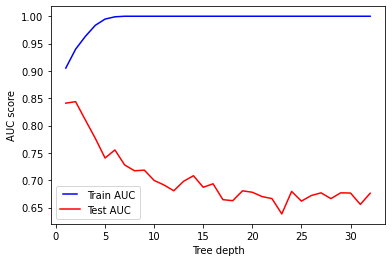

In [359]:
max_depths = range(1,33)
train_results = []
test_results = []
for max_depth in max_depths:
   model = GradientBoostingClassifier(max_depth=max_depth)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, color ='blue', label='Train AUC')
line2, = plt.plot(max_depths, test_results, color ='red', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

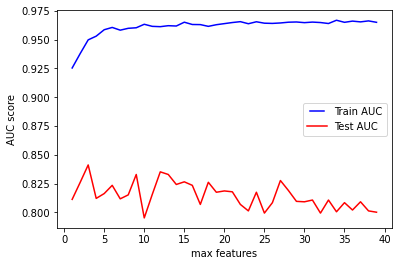

In [360]:
max_features = list(range(1,40))
train_results = []
test_results = []
for max_feature in max_features:
   model = GradientBoostingClassifier(max_features=max_feature)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, color='blue', label='Train AUC')
line2, = plt.plot(max_features, test_results, color='red', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.figsize = (12,10)
plt.show()

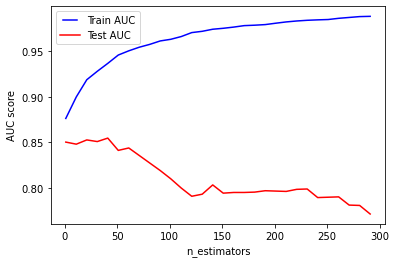

In [362]:
n_estimators = list(range(1,301,10))
train_results = []
test_results = []
for estimator in n_estimators:
   model = GradientBoostingClassifier(n_estimators=estimator)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, color='blue', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, color='red', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.figsize = (20,15)
plt.show()

- EDA, 

- Train Test Split

Preprocessing

- Scaling (fit on train, trasform test
- Oversampling 
- Clustering, Dimension Reduction, PCA


- KNN, LogReg, l1, l2, Gradient Boosting (Learning Rate), Decision Tree, RandomForest, Neural Network, 

# Sample

In [410]:
sam = df.sample(100)

In [411]:
X_sam = sam.drop('Bankrupt?', axis=1)
y_sam = sam['Bankrupt?']

In [412]:
X_sam

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Expense Rate,Research and development expense rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),...,Quick Asset Turnover Rate,Cash Turnover Rate,Fixed Assets to Assets,Current Liability to Liability,Equity to Long-term Liability,Current Liability to Current Assets,Liability-Assets Flag,Total assets to GNP price,Degree of Financial Leverage (DFL),Equity to Liability
4808,0.558816,0.621784,0.603458,5.830000e+09,1.550000e+09,0.000000,0.162365,0.200834,0.200834,0.200834,...,1.364781e-04,3.990000e+09,0.014218,0.949561,0.110933,0.016215,0,0.003510,0.026791,0.064898
169,0.496563,0.559202,0.546496,6.600000e+09,0.000000e+00,0.000184,0.176030,0.184400,0.184400,0.184400,...,6.010000e+09,1.410000e+09,0.134172,0.271954,0.115248,0.019432,0,0.013585,0.026833,0.056220
192,0.469702,0.539468,0.524118,2.481559e-04,4.580000e+08,0.000462,0.000000,0.170916,0.170916,0.170916,...,5.260000e+09,2.970000e+09,0.192851,0.847615,0.110933,0.045875,0,0.007634,0.027546,0.049225
6579,0.523473,0.561710,0.553884,6.629440e-04,5.638572e-04,0.000000,0.483652,0.180776,0.180776,0.180776,...,3.949767e-04,8.163853e-04,0.015633,0.473052,0.110933,0.002209,0,0.000340,0.026792,0.184556
1734,0.583386,0.632959,0.618181,9.840000e+09,3.740000e+09,0.000175,0.212673,0.207534,0.207534,0.207534,...,1.474462e-04,4.070000e+09,0.029947,0.985420,0.110933,0.019952,0,0.001888,0.026796,0.037971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2432,0.491396,0.561055,0.543552,7.850000e+09,0.000000e+00,0.000308,0.072072,0.194808,0.194808,0.194808,...,7.350000e+09,9.520000e+09,0.036395,0.900772,0.115993,0.029094,0,0.006890,0.026877,0.018483
411,0.453810,0.482119,0.504417,1.232685e-04,0.000000e+00,0.000169,0.000000,0.182715,0.182715,0.182715,...,1.811407e-04,1.693853e-04,0.601938,0.981282,0.110933,0.039458,0,0.002432,0.026754,0.050687
3107,0.532297,0.578936,0.577815,2.234097e-04,2.340000e+09,0.000352,0.230590,0.177869,0.177869,0.177869,...,1.092409e-04,3.160000e+09,0.220372,0.908115,0.111274,0.024513,0,0.000522,0.026821,0.036739
5568,0.468971,0.507141,0.526259,1.936911e-04,9.360000e+09,0.000308,0.000000,0.179976,0.179976,0.179976,...,1.843166e-04,7.490000e+09,0.562229,0.692756,0.124148,0.047512,0,0.001977,0.026653,0.020015


best_gb_model, best_rf_model

In [413]:
best_gb_model.predict(X_sam)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [416]:
y_sam.unique()

array([0, 1])

In [418]:
y_sam[y_sam==1]

1026    1
1751    1
1447    1
Name: Bankrupt?, dtype: int64

In [419]:
y_sam[1026]

1

In [423]:
df.iloc[1026]

Bankrupt?                                                   1.000000e+00
 ROA(C) before interest and depreciation before interest    4.338712e-01
 ROA(A) before interest and % after tax                     4.437418e-01
 ROA(B) before interest and depreciation after tax          4.695648e-01
 Operating Expense Rate                                     7.910000e+09
 Research and development expense rate                      2.000000e+09
 Interest-bearing debt interest rate                        5.740574e-04
 Tax rate (A)                                               0.000000e+00
 Net Value Per Share (B)                                    1.476971e-01
 Net Value Per Share (A)                                    1.476971e-01
 Net Value Per Share (C)                                    1.476971e-01
 Persistent EPS in the Last Four Seasons                    1.624279e-01
 Revenue Per Share (Yuan ¥)                                 6.134580e-02
 Operating Profit Per Share (Yuan ¥)               